#### Writing the icechunk store for the GAGES-9000

In [1]:
from pathlib import Path

import icechunk
import numpy as np
import xarray as xr
import zarr
from icechunk.xarray import to_icechunk

To make sure we can push to the repo, we will need to add AWS credentials to our `~/.aws/credentials` under the profile name "CIROH_USER"

In [2]:
import boto3
import os

profile_name = "CIROH_USER"  # Replace with your AWS credentials file profile name
os.environ['AWS_PROFILE'] = profile_name

In [3]:
file_path = Path("/projects/mhpi/data/observations/gages_9000.zarr")
bucket="mhpi-spatial"
prefix="usgs_streamflow_observations"
commit="initial streamflow commit"

In [17]:
if file_path.exists() is False:
    raise FileNotFoundError(f"Cannot find: {file_path}")
root = zarr.open_group(file_path)
keys = list(root.keys())

Converting the cfs obs to cms, getting the dates list, then writing the zarr group to an xarray dataset. Then, we store it as an icechunk store

In [18]:
def convert_ft3_s_to_m3_s(flow_rates_ft3_s: np.ndarray) -> np.ndarray:
    """
    Convert a 2D tensor of flow rates
    from cubic feet per second (ft³/s) to cubic meters per second (m³/s).
    """
    conversion_factor = 0.0283168
    return flow_rates_ft3_s * conversion_factor

In [43]:
import pandas as pd
from datetime import datetime, timedelta

obs_data = np.zeros([len(keys), root[keys[0]].shape[0]])  # dims: gage, time

origin_start_date = "1980/01/01"
start_date = pd.to_datetime(origin_start_date)
date_list = pd.date_range(start=start_date, periods=14610, freq='D')  # total number of timesteps
date_list[0:5]

DatetimeIndex(['1980-01-01', '1980-01-02', '1980-01-03', '1980-01-04',
               '1980-01-05'],
              dtype='datetime64[ns]', freq='D')

In [44]:
for idx, key in enumerate(keys):
    data_obs = root[key]
    obs_data[idx, :] = data_obs
_observations = convert_ft3_s_to_m3_s(obs_data)

ds = xr.Dataset(
    data_vars=dict(
        streamflow=(["gage_id", "time"], _observations)
    ),
    coords=dict(
        gage_id=keys,
        time=date_list,
    ),
    attrs=dict(
        description="GAGES-9000 training data",
        time_units="Days",
        streamflow_units="m3/s"
    )
)

In [45]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:     (gage_id: 9067, time: 14610)
Coordinates:
  * gage_id     (gage_id) <U15 544kB '01011000' '01017000' ... '401733105392404'
  * time        (time) datetime64[ns] 117kB 1980-01-01 1980-01-02 ... 2019-12-31
Data variables:
    streamflow  (gage_id, time) float64 1GB 18.69 18.26 17.84 ... nan nan nan
Attributes:
    description:       GAGES-9000 training data
    time_units:        Days
    streamflow_units:  m3/s

Now, we define our storage parameters, and can write the dataset to the cloud. Uncomment the below lines to upload

In [ ]:
# storage_config = icechunk.s3_storage(
#     bucket=bucket,
#     prefix=prefix,
#     region="us-east-2",
#     from_env=True
# )
# repo = icechunk.Repository.create(storage_config)
# session = repo.writable_session("main")
# to_icechunk(ds, session)
# first_snapshot = session.commit(commit)
# print(f"Data is uploaded. Commit: {first_snapshot}")

/home/tbindas/tbindas/.conda/envs/nwm_batcher/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/home/tbindas/tbindas/.conda/envs/nwm_batcher/lib/python3.12/site-packages/zarr/core/array.py:4257: UserWarning: The dtype `<U15` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  meta = AsyncArray._create_metadata_v3(


Data is uploaded. Commit: 9Q9V6TCEBJKY3A6AE58G


In [47]:
storage_config = icechunk.s3_storage(
bucket=bucket, prefix=prefix, region="us-east-2", anonymous=True
)
repo = icechunk.Repository.open(storage_config)
session = repo.readonly_session("main")
cloud_ds = xr.open_zarr(session.store, consolidated=False)

xr.set_options(display_style="text")
cloud_ds

/home/tbindas/tbindas/.conda/envs/nwm_batcher/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


<xarray.Dataset> Size: 1GB
Dimensions:     (gage_id: 9067, time: 14610)
Coordinates:
  * gage_id     (gage_id) object 73kB '01011000' ... '401733105392404'
  * time        (time) datetime64[ns] 117kB 1980-01-01 1980-01-02 ... 2019-12-31
Data variables:
    streamflow  (gage_id, time) float64 1GB dask.array<chunksize=(284, 914), meta=np.ndarray>
Attributes:
    description:       GAGES-9000 training data
    time_units:        Days
    streamflow_units:  m3/s

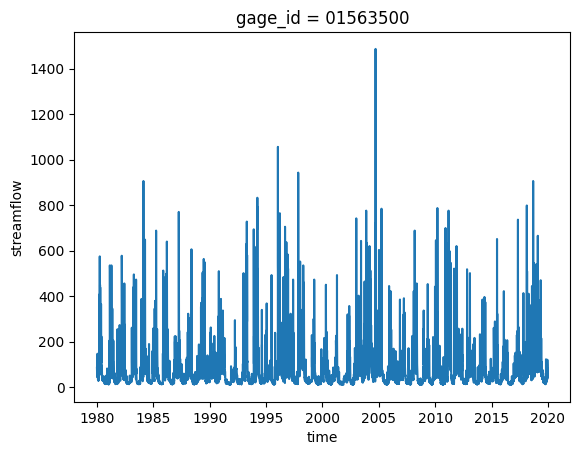

In [52]:
cloud_ds["streamflow"].sel(gage_id="01563500").plot()